# **Recurrent Neural Networks**

How to use RNN cells and their variants in PyTorch. Train a simple RNN performing word language classification given sequence of characters.

Remember how a recurrent neural network (folded) and its equivalent unfolded version is made:

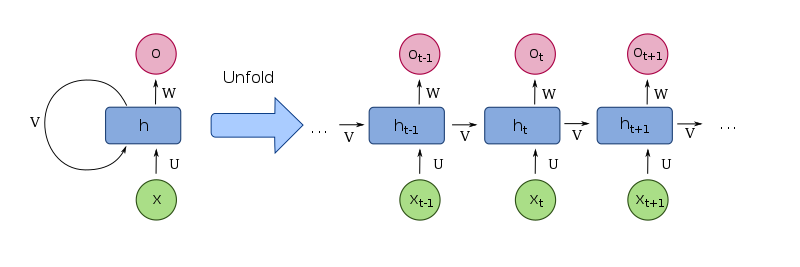

In PyTorch every variant has a corresponding layer:

- `torch.nn.RNN`
- `torch.nn.GRU`
- `torch.nn.LSTM`

A recurrent layer processes the whole input sequence, automatically producing output and hidden states (+ cell states for LSTMs). The input is given in the form SxNxC where S is the length of the sequence, N the batch size and C the number of features.

In [3]:
import torch
from torch import nn

In [5]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNN, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.RNN(input_size, hidden_size)
    self.i20 = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

    output, _ = self.i2h(input, hidden)
    output = self.i20(output[-1])

    return output.view(-1, self.output_size)
  
  def init_hidden(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)

In [6]:
class SimpleLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.LSTM(input_size, hidden_size)
    self.i20 = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden=None, cell=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

    if cell == None:
      cell = self.init_hidden(input.shape[1])
    
    output, (_, _) = self.i2h(input, (hidden, cell))
    output = self.i20(output[-1])

    return output.view(-1, self.output_size)

  def init_hidden(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)

  def init_cell(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)

As an alternative to layers, there are cells:

- `torch.nn.RNNCell`
- `torch.nn.GRUCell`
- `torch.nn.LSTMCell`

A cell does not process the whole sequence but just a single sample. Given an input and hidden state, it produces the output and the hidden state for the current timestamp. A full forward pass of a cell over the input sequence requires a for loop.

In [7]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNN, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.RNNCell(input_size, hidden_size)
    self.i2o = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

    for i in range(input.shape[0]):
      hidden = self.i2h(input[i], hidden)
      output = self.i20(hidden)

    return output

  def init_hidden(self, shape=1):
    return torch.zeros(shape, self.hidden_size)

So, if you are implementing the `forward` considering RNNCell:

```
#self.rnn = self.RNNCell(input_size, hidden_size)
def forward(self, x):
  h = self.get_hidden()
  for input in x:
    h = self.rnn(input, h)
```

While, if you are considering the implementation of the entire layer:

```
#self.rnn = self.RNN(input_size, hidden_size)
def forward(self, x):
  h_0 = self.get_hidden()
  output, h = self.rnn(x, h_0)
```

# **Data Preprocessing**

When training on sequences keep in mind that the input must always be encoded as a Tensor (e.g., characters can be encoded as 1-hot vectors, with a 1 in the alphabetical position of the character).

If the batch size is larger than 1 and the sequences have different lengths, they cannot be converted to a unique Tensor. To this extent you can:

- Use padding to make all sequences of the same length. PyTorch has `torch.nn.utils.rnn.pad_sequence(sequences, padding_value=0)`

- Pack the sequences together in a `PackedSequence`

The second method is usually slower and not optimized for GPU.

# **Tutorial on Recurrent Neural Networks**

Recurrent Neural Networks (RNN) are models which are useful anytime we want to model sequences of data (e.g., video, text). In this tutorial we will see how we can predict the language of a name using an RNN model taking single word characters as input.

Specifically, we will train the network on a list of surnames from 18 languages of origin, and predict which language a name is from, based on the spelling:

```
$ python predict.py Hinton
(0.63) Scottish
(0.22) English
(0.02) Irish
```
```
$ python predict.py Schmidhuber

(0.83) German
(0.08) Czech
(0.07) Dutch
```


# **Preparing the data**

The link to download the needed data is provied within the official pytorch tutorial. The data must be downloaded and extracted in your virtual machine:

In [9]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2022-08-19 14:20:20--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.36, 13.226.52.90, 13.226.52.128, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  15.2MB/s    in 0.2s    

2022-08-19 14:20:21 (15.2 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/I

Under the downloaded directory there are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line. In the following, we will take care of data preprocessing by:

- Extracting all the names and numbers of categories from the files.
- Converting from Unicode to ASCII each name
- Instantiating a dictionary containing all names (values) of a given language (key).

In [36]:
import glob
import string
#!pip install unidecode
from unidecode import unidecode

all_filenames = glob.glob('data/names/*.txt')
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
print(unidecode('Ślusàrski'))

Slusarski


In [54]:
# Build the category_lines dictionary
#its keys are the language and its values list of names for that language

category_lines = {}
all_categories = []


for f in all_filenames:
  # take the current language name
  cat = f.split('/')[-1].strip('.txt')
  all_categories.append(cat)

  # Iterate over all the lines of the current file
  with open(f) as reader:
    l = reader.readline()
    while l:
      # decode the name
      decoded = unidecode(l).rstrip()
      l = reader.readline()
      if cat not in category_lines:
        category_lines[cat] = [decoded]
      else:
        category_lines[cat].append(decoded)

n_categories = len(all_categories)

print(f'n_categories: {n_categories}')

n_categories: 18


# **Turning Names into Tensors**

A crucial point in this problem is how to define the input to the network. Since the network treats numbers and not plain text, we must convert text to numerical representation. To this extend we represent each letter as a one-hot vector of size $(1, \text{n_letters})$. A one-hot vector is filled with 0s, except for a 1 at index of the current letter:

$b \rightarrow \begin{bmatrix}0 & 1 & 0 & \ldots & 0\end{bmatrix}$

To make a word we join a bunch of those into a 2D matrix $(\text{line_length}, 1, \text{n_letters})$.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [84]:
import torch
import torch.nn as nn

In [85]:
# Just for demonstration, turn a letter into a (1, n_letters) Tensor

def letter_to_tensor(letter):
  tensor = torch.zeros(1, n_letters)
  letter_index = all_letters.find(letter)
  tensor[0, letter_index] = 1
  return tensor

letter_to_tensor('b')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [86]:
# Turn a line into a (line_length, n_letters).
# (or (line_length, 1, n_letters) if the batch dimension is added)
# of one-hot letter vectors
# Line is a sequence of characters

def line_to_tensor(line, add_batch_dimension=True):
  tensor = torch.zeros(len(line), n_letters)
  for line_index, letter in enumerate(line):
    letter_index = all_letters.find(letter)
    tensor[line_index, letter_index] = 1

  if add_batch_dimension:
    tensor = tensor.unsqueeze(1)

  return tensor

line_to_tensor('cognome').size()

torch.Size([7, 1, 57])

In [87]:
# Create a batch of samples given a list of lines
# That is, a list of character sequences

def create_batch(lines):
  tensors = []
  for current_line in lines:
    # current_line_tensor is (line_length, n_letters)
    current_line_tensor = line_to_tensor(current_line, add_batch_dimension=False)
    tensors.append(current_line_tensor)
  
  # since each line_tensor may have a different line_length we add each one to
  # the length of the longest sequence
  padded_tensor = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=False, padding_value=0)
  # padded_tensor is (max_line_length, batch_size, n_letters)
  return padded_tensor

# **Creating the Network**

Instantiate a simple recurrent neural network. The network should have a recurrent layer followed by a fully connected layer mapping the features of the recurrent unit to the output space (i.e. number of categories).

To run a step of this network we need to pass an input (in our case, the Tensor for the current sequence/s) and a previous hidden state (which we initialize as zeros at first). We'll get back the logits (i.e. network activation before the softmax) for each language.

In [88]:
# Create a simple recurrent network
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNN, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.RNN(input_size, hidden_size)
    self.i20 = nn.Linear(hidden_size, output_size)

  # forward the whole sequence at once
  def forward(self, input, hidden=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

      output, _ = self.i2h(input, hidden)
      # Only the fetures extracted at the en of the sequence are used
      # to produce the output
      output = self.i20(output)[-1]

      return output
  
  # Instantiate the hidden state of the first element of the sequence dim: (1 x batch_size x hidden_size)
  def init_hidden(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)

In [89]:
class SimpleLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.LSTM(input_size, hidden_size)
    self.i2o = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden=None, cell=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

    if cell == None:
      cell = self.init_hidden(input.shape[1])

    output, (_, _) = self.i2h(input, (hidden, cell))
    output = self.i20(output[-1])

    return output
  
  def init_hidden(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)
  
  def init_cell(self, shape=1):
    return torch.zeros(1, shape, self.hidden_size)

In [90]:
class SimpleRNNwithCell(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNNwithCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.i2h = nn.RNNCell(input_size, hidden_size)
    self.i2o = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden=None):
    if hidden == None:
      hidden = self.init_hidden(input.shape[1])

    # Manually feed each sequence element to the RNN cell
    for i in range(input.shape[0]):
      hidden = self.i2h(input[i], hidden)

    output = self.i2o(hidden)

    return output

  def init_hidden(self, shape=1):
    return torch.zeros(shape, self.hidden_size)

# **Preparing for Training**

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a logits of each category. We can use `Tensor.topk` to get the index of the greatest value

In [91]:
def category_from_output(output):
  # Returns top_k_values, top_k_indices
  top_values, top_idx = output.data.topk(1)
  category_idx = top_idx[0][0] # Get the index for the top value of the first batch element
  return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its language):

In [92]:
import random

def random_training_pair(batch_size=1):
  lines = []
  categories = []

  # Each batch element is a random line from a random language
  for b in range(batch_size):
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])

    lines.append(line)
    categories.append(category)

  # Builds the ground truth labels
  categories_tensor = torch.LongTensor([all_categories.index(c) for c in categories])
  # Uses our previous helper function to build the batch
  # from a list of sequences of characters
  lines_tensor = create_batch(lines)

  return categories_tensor, lines_tensor

# **Training the Network**

Since the output of the networks are logits and the task is classirication, we can use a standard cross-entropy loss.

In [93]:
criterion = nn.CrossEntropyLoss()

Now we instantiate a standard training loop where we will:

- Forward the input to the network
- Compute the loss
- Backpropagate it
- Do a step of the optimizer
- Reset the optimizer/network's grad

In [94]:
def train(model, optimizer, categories_tensor, lines_tensor):
  optimizer.zero_grad()
  
  output = model(lines_tensor)

  loss = criterion(output, categories_tensor)
  
  loss.backward()

  optimizer.step()


  return output, loss.item()

Now we just have to:
- Instantiate the network
- Instantiate the optimizer
- Run the training steps for a given number of iterations

In [98]:
# Init the network
n_hidden = 128
model = SimpleRNN(n_letters, n_hidden, n_categories)

#Init the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

# Initialize the training loop

batch_size = 2
n_iterations = int(1e5)
print_every = int(5e3)

# Keep track of losses

current_loss = 0

for it in range(1, n_iterations + 1):
  # Get a random training input and target
  category_tensor, line_tensor = random_training_pair(batch_size=batch_size)

  # Process it through the train function
  output, loss = train(model, optimizer, category_tensor, line_tensor)

  # Accumulate it through the train function
  current_loss += loss

  # Print iteration number and loss
  if it % print_every == 0:
    print('%d %d%% %.4f' % (it, it / n_iterations * 100, current_loss/print_every))
    current_loss = 0

5000 5% 2.8327
10000 10% 2.4468
15000 15% 2.1643
20000 20% 1.9951
25000 25% 1.8956
30000 30% 1.8337
35000 35% 1.7689
40000 40% 1.7536
45000 45% 1.6637
50000 50% 1.6441
55000 55% 1.6267
60000 60% 1.6004
65000 65% 1.5316
70000 70% 1.5063
75000 75% 1.4812
80000 80% 1.4588
85000 85% 1.4215
90000 90% 1.3824
95000 95% 1.3732
100000 100% 1.3143


# **Running on User Input**

Finally, following the original tutorial, we instantiate a prediction function and test on some user defined inputs.

In [106]:
normalizer = torch.nn.Softmax(dim=1)

def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  output = model(line_to_tensor(input_line))
  output = normalizer(output)
  # Get top N categories
  top_values, top_index = output.data.topk(n_predictions, 1, True)
  predictions = []

  for i in range(n_predictions):
    value = top_values[0][i] # 0 indices the first batch elements
    category_index = top_index[0][i]
    print('%.2f %s' %(value, all_categories[category_index]))
    predictions.append([value, all_categories[category_index]])


predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
0.36 Russian
0.35 Czech
0.17 English

> Jackson
0.89 Scottish
0.07 English
0.01 Russian

> Satoshi
0.74 Japanese
0.08 Greek
0.08 Arabic
